* baselines
    * Edit distance
    * Q-gram
    * Bloom filter
    * Transformer + Sup. SimCSE
    * GEAN + Sup. SimCSE

# Edit distance

In [2]:
import os
import torch
import warnings
import torchmetrics
import numpy as np
from loguru import logger
from torchmetrics.functional.regression import cosine_similarity

from const import *
from data import load_data, get_dataloader

warnings.filterwarnings('ignore')
start_threshold, end_threshold = 0.5, 0.851

/opt/conda/envs/main/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /opt/conda/envs/main/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZNK3c1010TensorImpl36is_contiguous_nondefault_policy_implENS_12MemoryFormatE
  warn(f"Failed to load image Python extension: {e}")


In [3]:
test_file_name = "triplet_both_test_5k.txt"
test_file_path = os.path.join(data_dir, test_file_name)
test_dl = get_dataloader(test_file_path, "eval", batch_size=128)

5000it [00:00, 59016.02it/s]


In [4]:
import textdistance
from pybloom import BloomFilter
from torchmetrics.classification import BinaryROC


def bloom_sorensen_similarity(text1, text2, q_gram_val=3):
    bf1 = BloomFilter(64, 0.001)
    bf2 =  BloomFilter(64, 0.001)
    for token in textdistance.find_ngrams(text1, q_gram_val):
        bf1.add("".join(token))
    for token in textdistance.find_ngrams(text2, q_gram_val):
        bf2.add("".join(token))
    return 2 * (bf1.bitarray & bf2.bitarray).count(1) / (bf1.bitarray.count(1) + bf2.bitarray.count(1))


def get_text_similarity(text_sim_func, eval_file_path):
    text_labels = []
    text_similarities = []
    with open(eval_file_path, "r", encoding="utf8") as f:
        for i, line in enumerate(f):
            line = line.strip().split("\t")
            anchor, positive, negative = "".join(line[0].split(" ")), "".join(line[2].split(" ")), "".join(line[4].split(" "))
            sim_match = text_sim_func(anchor, positive)
            text_labels.append(1)
            text_similarities.append(sim_match)
            sim_nonmatch = text_sim_func(anchor, negative)
            text_labels.append(0)
            text_similarities.append(sim_nonmatch)
    return text_labels, text_similarities


def get_semantic_similarity(model, dev_dl):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()
    # 计算pairs之间的相似度
    y_prob = []
    y_true = []
    with torch.no_grad():
        for batch_idx, source in enumerate(dev_dl):
            real_batch_num = source.get('input_ids').shape[0]
            input_ids = source.get('input_ids').view(real_batch_num * 3, -1).to(device)
            attention_mask = source.get('attention_mask').view(real_batch_num * 3, -1).to(device)
            token_type_ids = source.get('token_type_ids').view(real_batch_num * 3, -1).to(device)
            out = model(input_ids, attention_mask, token_type_ids)
            idx = torch.arange(out.shape[0], device=device).unsqueeze(1)
            # 三元组 (anchor, positive, negetive)
            anchor = out.index_select(0, torch.where(idx % 3 == 0)[0])
            positive = out.index_select(0, torch.where(idx % 3 == 1)[0])
            negative = out.index_select(0, torch.where(idx % 3 == 2)[0])

            # y_true、y_pred、y_prob
            sim_1 = cosine_similarity(anchor, positive, 'none')
            sim_0 = cosine_similarity(anchor, negative, 'none')
            y_prob.extend(sim_1)
            y_prob.extend(sim_0)
            y_true.extend([1] * len(sim_1))
            y_true.extend([0] * len(sim_0))
    y_prob = torch.tensor(y_prob).view(-1, 1).to(device)
    y_true = torch.tensor(y_true).view(-1, 1).to(device)
    return y_true, y_prob


def get_roc(y_true, y_prob, roc_thresholds=20):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    y_prob = torch.tensor(y_prob).view(-1, 1).to(device)
    y_true = torch.tensor(y_true).view(-1, 1).to(device)
    ROC = BinaryROC(thresholds=roc_thresholds).to(device)
    fpr, tpr, thresholds = ROC(y_prob, y_true)
    ROC.reset()
    return fpr.cpu(), tpr.cpu()

# 数据集统计分析

In [39]:
def get_average_text_similarity(text_sim_func, eval_file_path):
    avg_sim_pos = 0
    avg_sim_neg = 0
    sample_count = 0
    with open(eval_file_path, "r", encoding="utf8") as f:
        for i, line in enumerate(f):
            line = line.strip().split("\t")
            anchor, positive, negative = "".join(line[0].split(" ")), "".join(line[2].split(" ")), "".join(line[4].split(" "))
            sim_match = text_sim_func(anchor, positive)
            avg_sim_pos += sim_match
            sim_nonmatch = text_sim_func(anchor, negative)
            avg_sim_neg += sim_nonmatch
            sample_count += 1
    return round(avg_sim_pos / sample_count, 4), round(avg_sim_neg / sample_count, 4)

In [40]:
RES_50K_PATH = os.path.join(data_dir, "triplet_residence_train_50k.txt")
INS_50K_PATH = os.path.join(data_dir, "triplet_institution_train_50k.txt")
RES_5K_PATH = os.path.join(data_dir, "triplet_residence_dev_5k.txt")
INS_5K_PATH = os.path.join(data_dir, "triplet_institution_dev_5k.txt")
TEST_5K_PATH = os.path.join(data_dir, "triplet_both_test_5k.txt")

RES_50K_AVGSIM_POS, RES_50K_AVGSIM_NEG = get_average_text_similarity(textdistance.levenshtein.normalized_similarity, RES_50K_PATH)
INS_50K_AVGSIM_POS, INS_50K_AVGSIM_NEG = get_average_text_similarity(textdistance.levenshtein.normalized_similarity, INS_50K_PATH)
RES_5K_AVGSIM_POS, RES_5K_AVGSIM_NEG = get_average_text_similarity(textdistance.levenshtein.normalized_similarity, RES_5K_PATH)
INS_5K_AVGSIM_POS, INS_5K_AVGSIM_NEG = get_average_text_similarity(textdistance.levenshtein.normalized_similarity, INS_5K_PATH)
TEST_5K_AVGSIM_POS, TEST_5K_AVGSIM_NEG = get_average_text_similarity(textdistance.levenshtein.normalized_similarity, TEST_5K_PATH)

In [41]:
print("RES-50K:", RES_50K_AVGSIM_POS, RES_50K_AVGSIM_NEG, (RES_50K_AVGSIM_POS + RES_50K_AVGSIM_NEG) / 2, RES_50K_AVGSIM_NEG - RES_50K_AVGSIM_POS)
print("INS-50K", INS_50K_AVGSIM_POS, INS_50K_AVGSIM_NEG, (INS_50K_AVGSIM_POS + INS_50K_AVGSIM_NEG) / 2, INS_50K_AVGSIM_NEG - INS_50K_AVGSIM_POS)
print("RES-5K", RES_5K_AVGSIM_POS, RES_5K_AVGSIM_NEG, (RES_5K_AVGSIM_POS + RES_5K_AVGSIM_NEG) / 2, RES_5K_AVGSIM_NEG - RES_5K_AVGSIM_POS)
print("INS-5K", INS_5K_AVGSIM_POS, INS_5K_AVGSIM_NEG, (INS_5K_AVGSIM_POS + INS_5K_AVGSIM_NEG) / 2, INS_5K_AVGSIM_NEG- INS_5K_AVGSIM_POS)
print("TEST-5K", TEST_5K_AVGSIM_POS, TEST_5K_AVGSIM_NEG, (TEST_5K_AVGSIM_POS + TEST_5K_AVGSIM_NEG) / 2, TEST_5K_AVGSIM_NEG - TEST_5K_AVGSIM_POS)

RES-50K: 0.539 0.823 0.681 0.2839999999999999
INS-50K 0.5568 0.8135 0.6851499999999999 0.25670000000000004
RES-5K 0.542 0.8236 0.6828000000000001 0.28159999999999996
INS-5K 0.5585 0.8127 0.6856 0.2542
TEST-5K 0.5502 0.8183 0.68425 0.2681


In [5]:
y_true_lev, y_prob_lev = get_text_similarity(textdistance.levenshtein.normalized_similarity, test_file_path)
fpr_lev, tpr_lev = get_roc(y_true_lev, y_prob_lev)

In [6]:
y_true_dice, y_prob_dice = get_text_similarity(textdistance.Sorensen(qval=3).normalized_similarity, test_file_path)
fpr_dice, tpr_dice = get_roc(y_true_dice, y_prob_dice)

In [7]:
y_true_bloom, y_prob_bloom = get_text_similarity(bloom_sorensen_similarity, test_file_path)
fpr_bloom, tpr_bloom = get_roc(y_true_bloom, y_prob_bloom)

In [8]:
unsupSimTran_model_path = os.path.join(model_dir, "2022-06-04/Federated/Transformer/Unsup-SimCSE/12:51:14-Federated_Transformer_Unsup-SimCSE-global.pt")
y_true_unsupSimTran, y_prob_unsupSimTran = get_semantic_similarity(torch.load(unsupSimTran_model_path), test_dl)

In [9]:
fpr_unsupSimTran, tpr_unsupSimTran = get_roc(y_true_unsupSimTran, y_prob_unsupSimTran)

In [10]:
unsupSimGEAN_model_path = os.path.join(model_dir, "2022-06-04/Federated/Transformer+GE-type+Entity-Pooler/Unsup-SimCSE/12:56:14-Federated_Transformer+GE-type+Entity-Pooler_Unsup-SimCSE-global.pt")
y_true_unsupSimGEAN, y_prob_unsupSimGEAN = get_semantic_similarity(torch.load(unsupSimGEAN_model_path), test_dl)

In [11]:
fpr_unsupSimGEAN, tpr_unsupSimGEAN = get_roc(y_true_unsupSimGEAN, y_prob_unsupSimGEAN)

In [12]:
supTripTran_model_path = os.path.join(model_dir, "2022-05-30/Federated/Transformer/Sup-Triplet/22:24:51-Federated_Transformer_Sup-Triplet-global.pt")
y_true_supTripTran, y_prob_supTripTran = get_semantic_similarity(torch.load(supTripTran_model_path), test_dl)

In [13]:
fpr_supTripTran, tpr_supTripTran = get_roc(y_true_supTripTran, y_prob_supTripTran)

In [14]:
supTripGEAN_model_path = os.path.join(model_dir, "2022-06-04/Federated/Transformer+GE-type+Entity-Pooler/Sup-Triplet/12:45:15-Federated_Transformer+GE-type+Entity-Pooler_Sup-Triplet-global.pt")
y_true_supTripGEAN, y_prob_supTripGEAN = get_semantic_similarity(torch.load(supTripGEAN_model_path), test_dl)

In [15]:
fpr_supTripGEAN, tpr_supTripGEAN = get_roc(y_true_supTripGEAN, y_prob_supTripGEAN)

In [16]:
supSimTran_model_path = os.path.join(model_dir, "2022-06-03/Federated/Transformer/Sup-SimCSE/23:52:29-Federated_Transformer_Sup-SimCSE-global.pt")
y_true_supSimTran, y_prob_supSimTran = get_semantic_similarity(torch.load(supSimTran_model_path), test_dl)

In [17]:
fpr_supSimTran, tpr_supSimTran = get_roc(y_true_supSimTran, y_prob_supSimTran)

In [18]:
supSimGEAN_model_path = os.path.join(model_dir, "2022-06-03/Federated/Transformer+GE-type+Entity-Pooler/Sup-SimCSE/21:17:10-Federated_Transformer+GE-type+Entity-Pooler_Sup-SimCSE-global.pt")
y_true_supSimGEAN, y_prob_supSimGEAN = get_semantic_similarity(torch.load(supSimGEAN_model_path), test_dl)

In [19]:
fpr_supSimGEAN, tpr_supSimGEAN = get_roc(y_true_supSimGEAN, y_prob_supSimGEAN)

In [20]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from pylab import cm
%matplotlib inline

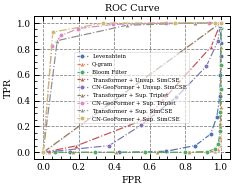

In [26]:
plt.style.use(['science', 'no-latex', 'grid', 'muted'])

# sns.set(style="whitegrid", color_codes=True)
sns.set_palette(sns.color_palette("deep"))
# sns.despine(right=False, top=True)
sns.set_context("paper")

# sns.lineplot(x=fpr_lev, y=tpr_lev, label="Levenshtein", ls='-.', marker='.', color="k")
# sns.lineplot(x=fpr_dice, y=tpr_dice, label="Q-gram", linestyle='-.', marker=".", color="purple")
# sns.lineplot(x=fpr_bloom, y=tpr_bloom, label="Bloom Filter", ls='-.', marker='.', color="g")
# sns.lineplot(x=fpr_gean, y=tpr_gean, label="GEAN", ls='-.', marker='.', color="r")
# sns.lineplot(x=fpr_trans, y=tpr_trans, label="Transformer", ls='-.', marker='.', color="b")

sns.lineplot(x=fpr_lev, y=tpr_lev, label="Levenshtein", ls='-.', marker='o')
sns.lineplot(x=fpr_dice, y=tpr_dice, label="Q-gram", linestyle='-.', marker='^')
sns.lineplot(x=fpr_bloom, y=tpr_bloom, label="Bloom Filter", ls='-.', marker='o')

sns.lineplot(x=fpr_unsupSimTran, y=tpr_unsupSimTran, label="Transformer + Unsup. SimCSE", ls='-.', marker='^')
sns.lineplot(x=fpr_unsupSimGEAN, y=tpr_unsupSimGEAN, label="CN-GeoFormer + Unsup. SimCSE", ls='-.', marker='o')

sns.lineplot(x=fpr_supTripTran, y=tpr_supTripTran, label="Transformer + Sup. Triplet", ls='-.', marker='^')
sns.lineplot(x=fpr_supTripGEAN, y=tpr_supTripGEAN, label="CN-GeoFormer + Sup. Triplet", ls='-.', marker='o')

sns.lineplot(x=fpr_supSimTran, y=tpr_supSimTran, label="Transformer + Sup. SimCSE", ls='-.', marker='^')
sns.lineplot(x=fpr_supSimGEAN, y=tpr_supSimGEAN, label="CN-GeoFormer + Sup. SimCSE", ls='-.', marker='o')


plt.title("ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend(loc='best', framealpha=0.6, fontsize='xx-small')
plt.savefig("figures/ROC curve for linkage quatity analysis.pdf", dpi=300)